In [1]:
import tensorflow as ts
import kagglehub
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

path = kagglehub.dataset_download("seanscully29/flowers-classification")

print("Path to dataset files:",path)



Path to dataset files: /kaggle/input/flowers-classification


In [2]:
local_path="./flower_species_dataset"
os.makedirs(local_path, exist_ok=True)

try:
  for item in os.listdir(path):
    s = os.path.join(path,item)
    d = os.path.join(local_path,item)
    if os.path.isdir(s):
      shutil.copytree(s,d)
    else:
      shutil.copy2(s,d)
except FileExistsError:
  print(f"{local_path} already exists.")


print(f"Dataset saved at: {local_path}")


Dataset saved at: ./flower_species_dataset


In [3]:
source_path="/content/flower_species_dataset/flowerdataset"
training_path='./flower_species_dataset/training'
testing_path='./flower_species_dataset/testing'
classes=["black_eyed_susan","calendula","california_poppy","coreopsis","iris"]

model_path="flower_dataset_model.h5"

for cls in classes:
  os.makedirs(os.path.join(training_path,cls),exist_ok=True)
  os.makedirs(os.path.join(testing_path,cls),exist_ok=True)

for cls in classes:
  files=os.listdir(os.path.join(source_path,cls))

  split=int(0.8 * len(files))
  training_files=files[:split]
  testing_files=files[split:]

  for t in training_files:
    shutil.move(os.path.join(source_path, cls, t),os.path.join(training_path,cls,t))
  for t in testing_files:
    shutil.move(os.path.join(source_path, cls, t),os.path.join(testing_path,cls,t))


In [4]:
# Define ImageDataGenerator for augmentation and rescaling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerato
import os

train_dir = training_path
test_dir = testing_path

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load testing dataset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 4079 images belonging to 5 classes.
Found 1022 images belonging to 5 classes.


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='sigmoid', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='sigmoid'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='sigmoid'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='sigmoid'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(1024, (3,3), activation='sigmoid'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dense(5, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history=model.fit(train_generator,epochs=5,validation_data=test_generator)
model.save(model_path)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.2022 - loss: 2.2795 - val_accuracy: 0.1918 - val_loss: 1.6174
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.2128 - loss: 1.6236 - val_accuracy: 0.2065 - val_loss: 1.6339
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 471s 4s/step - accuracy: 0.1916 - loss: 1.6271 - val_accuracy: 0.2006 - val_loss: 1.6248
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.2029 - loss: 1.6186 - val_accuracy: 0.2065 - val_loss: 1.6245
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.1904 - loss: 1.6281 - val_accuracy: 0.2055 - val_loss: 1.6213


In [7]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 839ms/step - accuracy: 0.1786 - loss: 1.6263
Test Accuracy: 0.21


Visualizing training results...


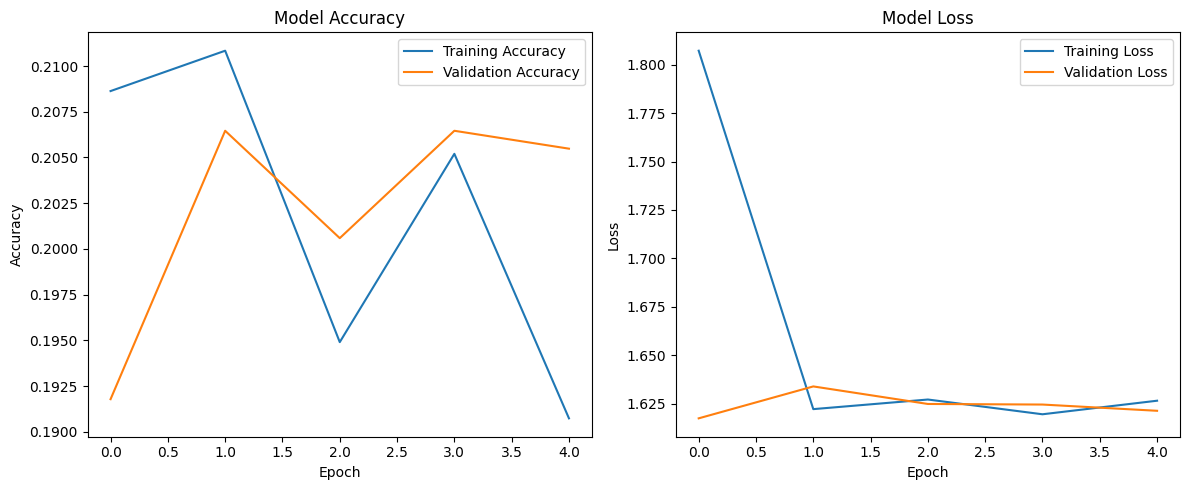

In [8]:
# === Visualization of training ===
print("Visualizing training results...")

# Plot accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_new_image(img_path):
    model = load_model(model_path)

    # Load image in color (RGB)
    img = Image.open(img_path).convert("RGB")
    img = img.resize((150, 150))

    img_array = np.array(img).astype("float32") / 255.0
    img_array = img_array.reshape(1, 150, 150, 3)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0][predicted_index]

    # Extract class name from the image path
    class_name = os.path.basename(os.path.dirname(img_path))

    # Display
    plt.imshow(img)
    plt.axis("off")
    # Assuming you have a 'classes' list defined somewhere with the class names
    # For example: classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    plt.title(f"Prediction: {classes[predicted_index]}, Accuracy: ({confidence:.2%})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


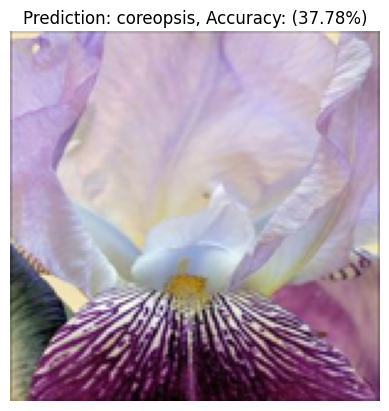

In [17]:
predict_new_image("/content/flower_species_dataset/testing/iris/167855937_652991da74_c.jpg")